# Hallucination Detection in AI Transcribed Audio SRT Files

This notebook explores a dataset of text repetitions to classify them as either **'hallucinations'** (unwanted, repetitive loops) or **'normal speech'**. 

We will visualize the data and train two types of classifiers to distinguish between these two classes:

1. **Logistic Regression (Linear Classifier)**
2. **Support Vector Machine (SVM)**

## Goal

Find a model that can effectively separate these two categories based on two key features:
- **`repetitions`**: The number of times a phrase is repeated consecutively
- **`sequence_length`**: The number of words in the repeated phrase (k)

## 1. Load and Explore the Data

First, let's load the dataset and examine its structure.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load the dataset
csv_path = Path("../data/analyze/hallucinations/test_examples_analysis.csv")
df = pd.read_csv(csv_path)

# Display the first few rows
print("First 5 rows of the dataset:")
print(df.head())
print()

# Display summary statistics
print("Dataset Information:")
print(df.info())
print()

print("Summary Statistics:")
print(df.describe())
print()

print("Class Distribution:")
print(df["is_hallucination"].value_counts())

First 5 rows of the dataset:
   repetitions  sequence_length  score  is_hallucination  \
0           15                3     45                 1   
1           40                1     40                 1   
2           40                1     40                 1   
3           10               13    130                 1   
4           11                1     11                 1   

                                                text  \
0  you know, like, you know, like, you know, like...   
1  Yeah. Yeah. Yeah. Yeah. Yeah. Yeah. Yeah. Yeah...   
2  and, and, and, and, and, and, and, and, and, a...   
3  We have to be able to do this with the X or Y....   
4  word word word word word word word word word w...   

                                         description  
0               Massive loop: 'you know, like,' × 15  
1       Single word massive repetition: 'Yeah.' × 40  
2        Single word massive repetition: 'and,' × 40  
3                      Long phrase repeated 10 times 

## 2. Visualize the Data

A scatter plot helps us understand the relationship between `repetitions` and `sequence_length` for both classes.

**Legend:**
- 🔵 Blue circles = Normal Speech (0)
- 🔺 Red triangles = Hallucination (1)

In [ ]:
def plot_data(X, y):  # noqa: ANN201, ANN001, N803
    """Plot scatter plot of data points colored by class."""
    fig, ax = plt.subplots(figsize=(10, 7))

    # Separate data by class
    X_normal = X[y == 0]  # noqa: N806
    X_hallucination = X[y == 1]  # noqa: N806

    # Plot data points
    ax.scatter(
        X_normal[:, 0],
        X_normal[:, 1],
        c="blue",
        marker="o",
        s=100,
        alpha=0.6,
        edgecolors="black",
        label="Normal Speech (0)",
    )
    ax.scatter(
        X_hallucination[:, 0],
        X_hallucination[:, 1],
        c="red",
        marker="^",
        s=150,
        alpha=0.8,
        edgecolors="black",
        label="Hallucination (1)",
    )

    ax.set_xlabel("Repetitions", fontsize=12)
    ax.set_ylabel("Sequence Length (k)", fontsize=12)
    ax.set_title("Hallucination vs. Normal Speech Data", fontsize=14, fontweight="bold")
    ax.grid(True, alpha=0.3, linestyle=":")
    ax.legend()

    return fig, ax


# Prepare data for plotting
X = df[["repetitions", "sequence_length"]].values
y = df["is_hallucination"].values

# Create and display plot
fig, ax = plot_data(X, y)
plt.tight_layout()
plt.show()

## 3. Train a Logistic Regression Classifier

Let's train a linear classifier using Logistic Regression and evaluate its performance using 5-fold cross-validation.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Initialize and train the model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X, y)

# Evaluate with cross-validation
cv_scores = cross_val_score(log_reg, X, y, cv=5)
print(f"Logistic Regression Cross-Validation Accuracy: {np.mean(cv_scores):.3f} (+/- {np.std(cv_scores):.3f})")

# Evaluate on the full training set
train_accuracy = log_reg.score(X, y)
print(f"Logistic Regression Training Accuracy: {train_accuracy:.3f}")

# Display model coefficients
coef = log_reg.coef_[0]
intercept = log_reg.intercept_[0]
print("\nModel Coefficients:")
print(f"  Repetitions: {coef[0]:.4f}")
print(f"  Sequence Length: {coef[1]:.4f}")
print(f"  Intercept: {intercept:.4f}")

Logistic Regression Cross-Validation Accuracy: 0.971 (+/- 0.057)
Logistic Regression Training Accuracy: 1.000

Model Coefficients:
  Repetitions: 1.0714
  Sequence Length: 0.7981
  Intercept: -9.1585


### 3.1 Visualize the Decision Boundary

The decision boundary shows where the model separates the two classes. Points on one side are classified as "Normal Speech" and points on the other side as "Hallucination".

In [ ]:
def plot_decision_boundary(ax, model):  # noqa: ANN201, ANN001
    """Plot the decision boundary for a trained classifier."""
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    # Create mesh grid
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

    # Predict on mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])  # noqa: N806
    Z = Z.reshape(xx.shape)  # noqa: N806

    # Plot filled contours (background colors)
    ax.contourf(xx, yy, Z, alpha=0.2, levels=[-0.5, 0.5, 1.5], colors=["blue", "red"])

    # Plot decision boundary line
    ax.contour(
        xx,
        yy,
        Z,
        levels=[0.5],
        colors="black",
        linewidths=2,
        linestyles="--",
    )
    return ax


# Plot the data and the decision boundary
fig, ax = plot_data(X, y)
ax.set_title("Logistic Regression Decision Boundary", fontsize=14, fontweight="bold")
plot_decision_boundary(ax, log_reg)
plt.tight_layout()
plt.show()

## 4. Train a Support Vector Machine (SVM) Classifier

Now let's train an SVM classifier with a linear kernel and compare its performance to Logistic Regression.

In [5]:
from sklearn.svm import SVC

# Initialize and train the model
svm_clf = SVC(kernel="linear", C=1.0, random_state=42)
svm_clf.fit(X, y)

# Evaluate with cross-validation
cv_scores_svm = cross_val_score(svm_clf, X, y, cv=5)
print(f"SVM Cross-Validation Accuracy: {np.mean(cv_scores_svm):.3f} (+/- {np.std(cv_scores_svm):.3f})")

# Evaluate on the full training set
train_accuracy_svm = svm_clf.score(X, y)
print(f"SVM Training Accuracy: {train_accuracy_svm:.3f}")

# Display model information
coef_svm = svm_clf.coef_[0]
intercept_svm = svm_clf.intercept_[0]
print("\nModel Coefficients:")
print(f"  Repetitions: {coef_svm[0]:.4f}")
print(f"  Sequence Length: {coef_svm[1]:.4f}")
print(f"  Intercept: {intercept_svm:.4f}")
print(f"\nSupport Vectors: {svm_clf.n_support_.sum()} total")

SVM Cross-Validation Accuracy: 0.943 (+/- 0.070)
SVM Training Accuracy: 1.000

Model Coefficients:
  Repetitions: 0.8888
  Sequence Length: 0.6665
  Intercept: -6.7771

Support Vectors: 3 total


### 4.1 Visualize the SVM Decision Boundary

Let's visualize the SVM decision boundary and compare it with the Logistic Regression boundary.

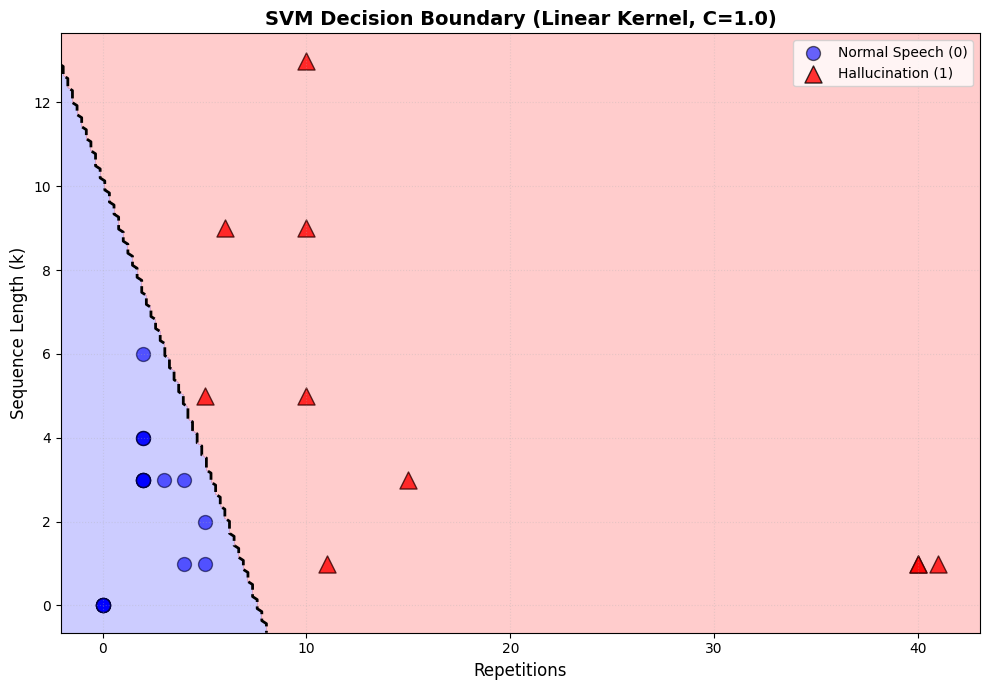

In [6]:
# Plot the data and the SVM decision boundary
fig, ax = plot_data(X, y)
ax.set_title("SVM Decision Boundary (Linear Kernel, C=1.0)", fontsize=14, fontweight="bold")
plot_decision_boundary(ax, svm_clf)
plt.tight_layout()
plt.show()

## 5. Conclusion

### Key Findings

Both the **Logistic Regression** and **SVM** classifiers perform very well on this dataset, achieving high accuracy in separating hallucinations from normal speech patterns.

### Observations

1. **Similar Performance**: The decision boundaries are very similar, indicating that for this particular problem, a simple linear separation is highly effective.

2. **Clear Separation**: The visualizations clearly show that hallucinations are characterized by:
   - High number of repetitions
   - High sequence length
   - Or a combination of both

3. **Model Effectiveness**: Both models are able to capture this relationship effectively with similar coefficients.

### Interpretation

The linear decision boundary works well because:
- **Hallucinations** tend to have both high repetition counts AND long sequences
- **Normal speech** has lower values for both features
- The relationship is approximately linear in the feature space

### Next Steps

Potential improvements could include:
- Testing on a larger, more diverse dataset
- Exploring polynomial features for non-linear boundaries
- Feature engineering (e.g., interaction terms, ratios)
- Collecting additional features beyond repetitions and sequence length